In [ ]:
import numpy as np
import ellc
import matplotlib.pyplot as plt

In [ ]:
# import lightkurve as lk

# lc = lk.search_lightcurvefile('alpha Draconis', mission='TESS').download_all().SAP_FLUX.stitch().remove_nans()

In [3]:
# t, y, yerr = lc.time, lc.flux, lc.flux_err

In [4]:
plt.rcParams['figure.dpi'] = 200

In [5]:
t, y, yerr = np.loadtxt('../data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
t0_guess = t[np.argmin(y)]

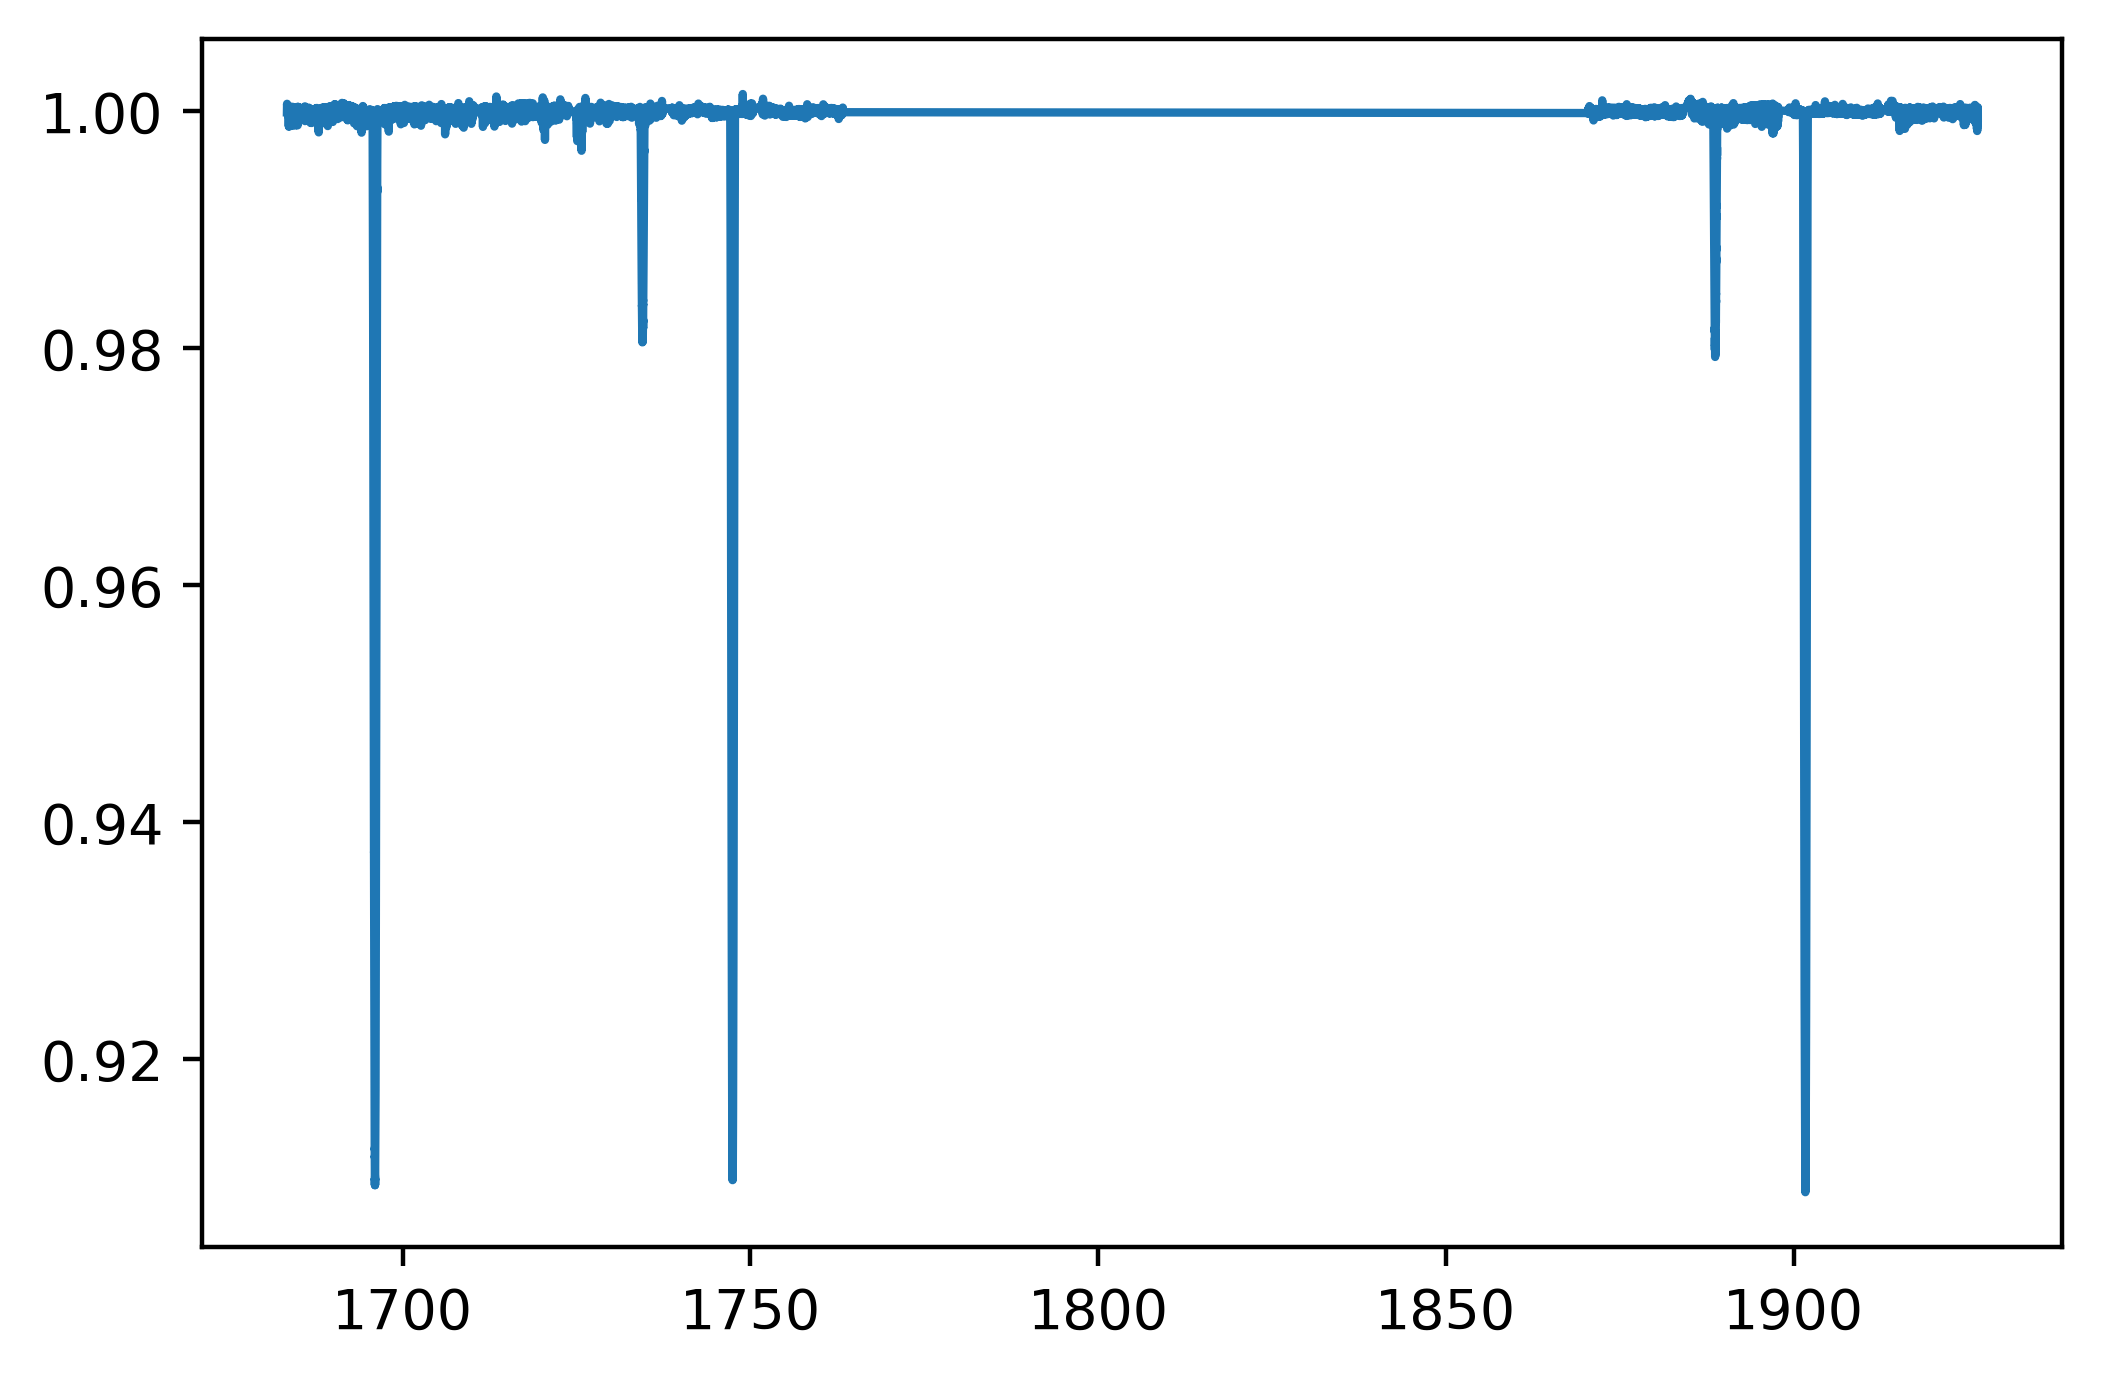

In [6]:
plt.plot(t,y)

Text(0, 0.5, 'Flux')

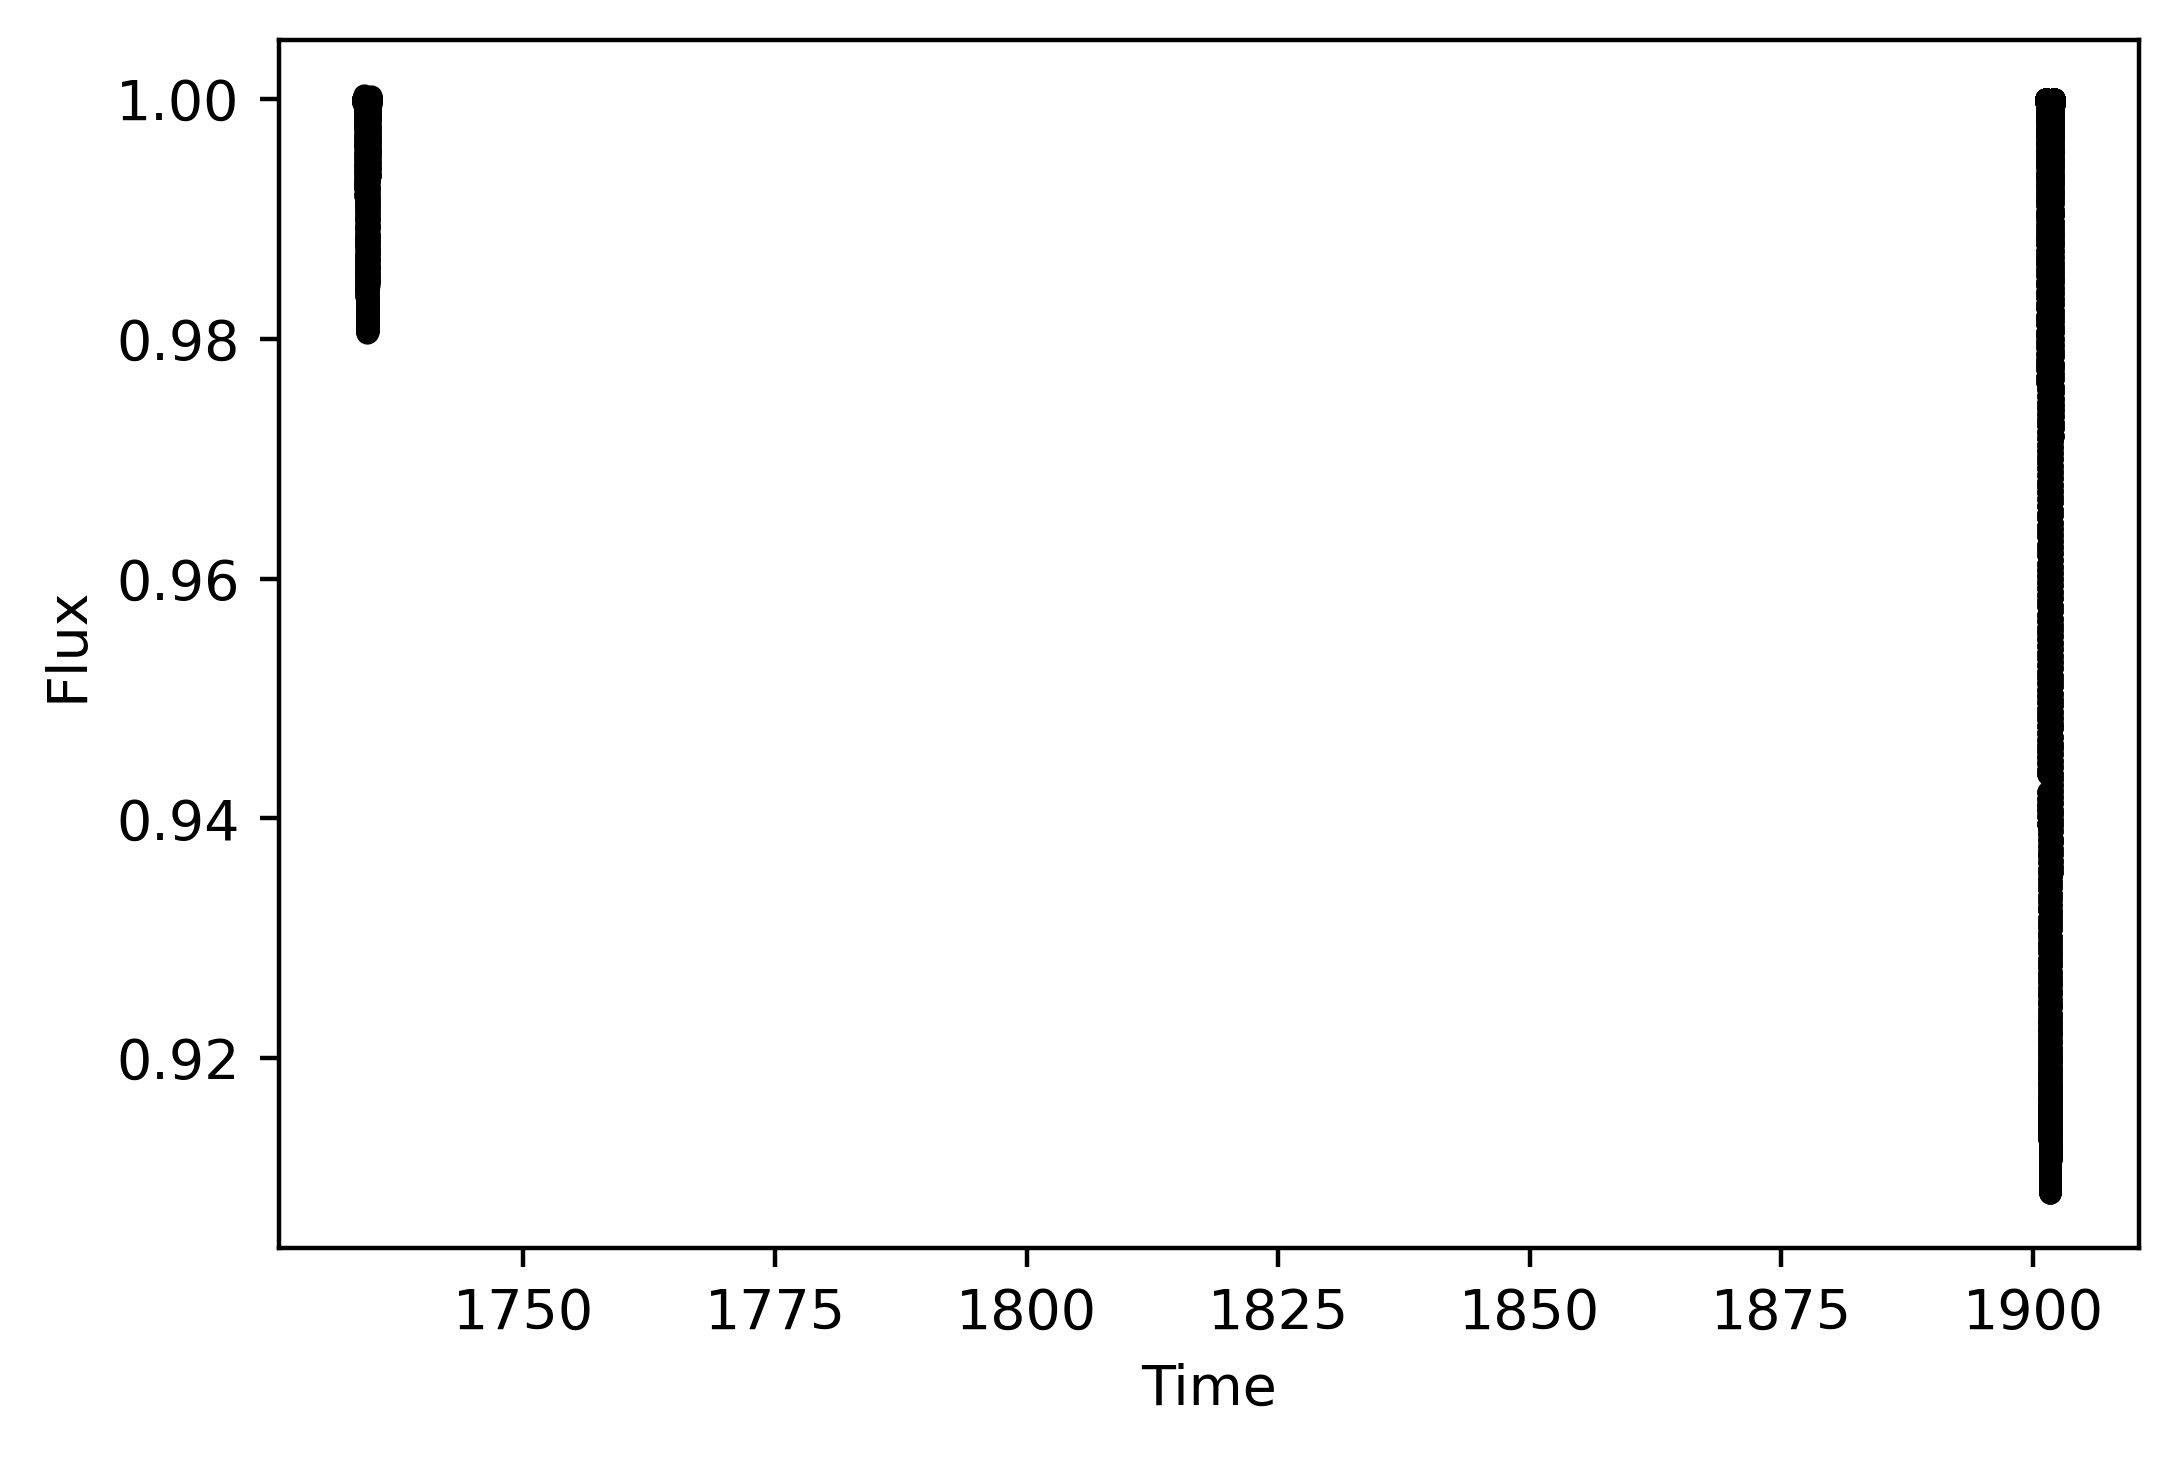

In [8]:
t0_guess = t[np.argmin(y)]

spacing = 0.4

y_transit = y[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
t_transit = t[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
yerr_transit = yerr[(t > t0_guess-spacing) & (t < t0_guess+spacing)]

plt.plot(t_transit, y_transit, '.k')
plt.xlabel('Time')
plt.ylabel('Flux')

t1_guess = t[t>1700][np.argmin(y[t>1700])]
y_transit2 = y[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
t_transit2 = t[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
yerr_transit2 = yerr[(t > t1_guess-spacing) & (t < t1_guess+spacing)]

t2_guess = t[(t>1700) & (t<1740)][np.argmin(y[(t>1700) & (t<1740)])]
y_transit3 = y[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
t_transit3 = t[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
yerr_transit3 = yerr[(t > t2_guess-spacing) & (t < t2_guess+spacing)]

plt.plot(t_transit, y_transit, '.k')
plt.plot(t_transit2, y_transit2, '.k')
plt.plot(t_transit3, y_transit3, '.k')

plt.xlabel('Time')
plt.ylabel('Flux')

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=mnras_size(513.11743))


ax1 = plt.subplot(223)
ax1.plot(t_transit, y_transit, '.k', markersize=2, rasterized=True)
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Normalised flux')
ax1.set_ylim(0.9, 1.01)
ax1.set_xlim(t0_guess - spacing, t0_guess+spacing)

ax2 = plt.subplot(224)
ax2.plot(t_transit2, y_transit2, '.k', markersize=2, rasterized=True)
ax2.set_yticks([])
ax2.ticklabel_format(useOffset=False)
ax2.set_ylim(0.9, 1.01)
ax2.set_xlim(t1_guess - spacing, t1_guess+spacing)
ax2.set_xlabel('Time (BJD - 2457000)')

ax = plt.subplot(211)
ax.plot(t,y, '.k', markersize=2, rasterized=True)
ax.set_xlim(t[0], t[-1])
ax.set_ylim(0.9, 1.01)

ax.set_xlabel('Time (BJD - 2457000)')
ax.set_ylabel('Normalised flux')
plt.subplots_adjust(hspace=0.3, wspace=0.1)
# plt.savefig('lc_plot.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

NameError: name 'mnras_size' is not defined

In [40]:
full_transit_time, full_transit_flux, full_transit_err = np.hstack([t_transit, t_transit2, t_transit3]), np.hstack([y_transit, y_transit2, y_transit3]), np.hstack([yerr_transit, yerr_transit2, yerr_transit3])
sort = np.argsort(full_transit_time)

full_transit_time = full_transit_time[sort][::20]
full_transit_flux = full_transit_flux[sort][::20]
full_transit_err = full_transit_err[sort][::20]

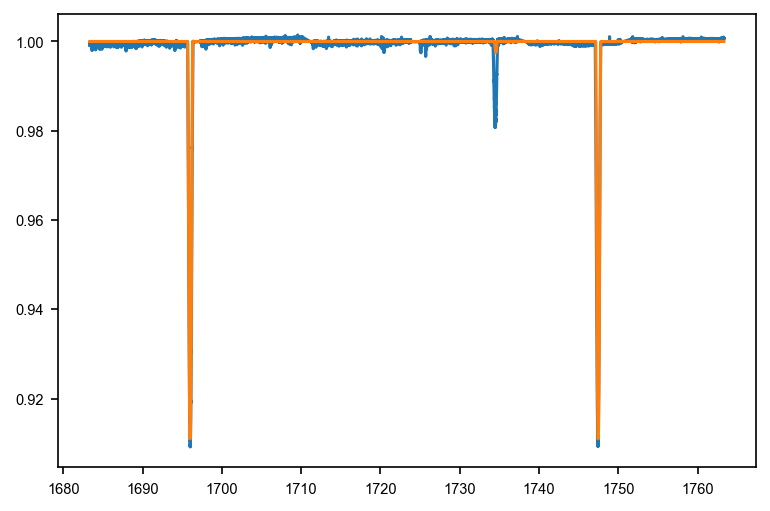

In [41]:
f_c = 0.6071025773236461
f_s = 0.24107770657401392

lc = ellc.lc(t,t_zero=t0_guess, q=1.,
         period=51.4617, f_c=f_c, f_s=f_s,radius_1=0.044, radius_2=0.026,
         incl=86, a=900,
         sbratio=0.7)


plt.plot(t, y)
plt.plot(t, lc)

In [42]:
def model(params, x):
    period, r1, r2, incl, sbratio, t0, f_c, f_s = params
#     r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    lc = ellc.lc(x,t_zero=t0, #q=q,
            radius_1=r1, radius_2=r2,
             incl=incl, #hf_1=h1, hf_2=h2,
             sbratio=sbratio, shape_1='roche', shape_2='roche',
             period=period, f_c=f_c, f_s=f_s)
    return lc# / np.max(lc)


def lnprior(params):
    period, r1, r2, incl, sbratio, t0, f_c, f_s = params
#     r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    if (70 < incl < 90) & (sbratio < 1.5) & ((t0_guess-1) < t0 < (t0_guess+1)):
        return 0.
    else:
        return -np.inf
    
def lnlike(params, x, y, yerr):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    try:
        model_flux = model(params, x)
        return -0.5*np.sum((y-model_flux)**2/yerr**2)
    except:
        return -np.inf
    
from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)

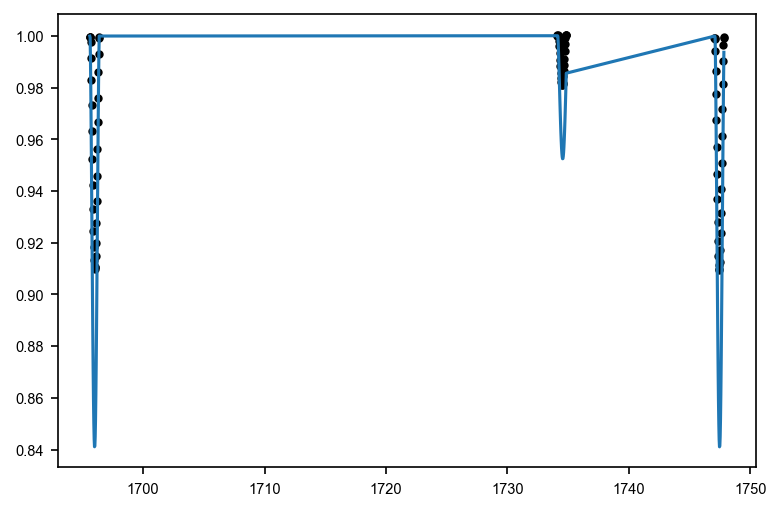

In [43]:
params = [51.4617, 
#           0.1, 0.323,
#           6.65722266e-02, 3.23674077e-01,
          0.0444, 0.026,
          86.86633416388645,0.7, t0_guess, f_c, f_s]
f_c, f_s = 0.6071025773236461, 0.24107770657401392, 
sbratio = 0.6


lc =model(params, full_transit_time)

plt.plot(full_transit_time,full_transit_flux, '.k')
plt.plot(full_transit_time, lc)

In [44]:
#plt.plot(full_transit_time, model(params, full_transit_time))
soln = minimize(nll, params, args=(full_transit_time, full_transit_flux, full_transit_err), 
                method='Nelder-Mead', tol=100
               )

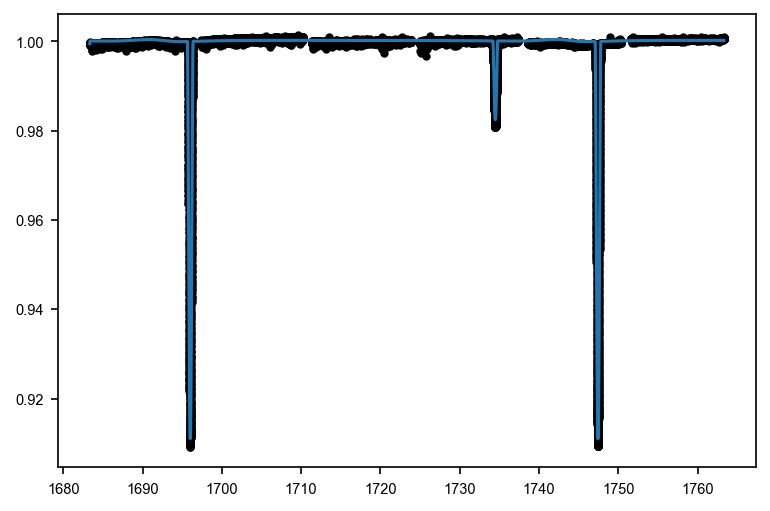

In [45]:
flux = model(soln['x'], t)
plt.plot(t,y, '.k')
plt.plot(t, flux)

In [21]:
soln.x

array([5.14193789e+01, 7.00797266e-02, 5.12826952e-01, 8.61791367e+01,
       6.99595586e-01, 1.69601968e+03, 6.05759303e-01, 2.41252539e-01])

In [14]:
import emcee

pos = soln.x + 1e-4*np.random.randn(32, len(soln.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(full_transit_time, full_transit_flux, full_transit_err))
sampler.run_mcmc(pos, 5000, progress=True);

/Users/danielhey/anaconda3/envs/phoebe/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 5000/5000 [15:14<00:00,  5.46it/s]


In [42]:
discard = 4000
flat_samples = sampler.get_chain(discard=discard,)
#                                  flat=True)

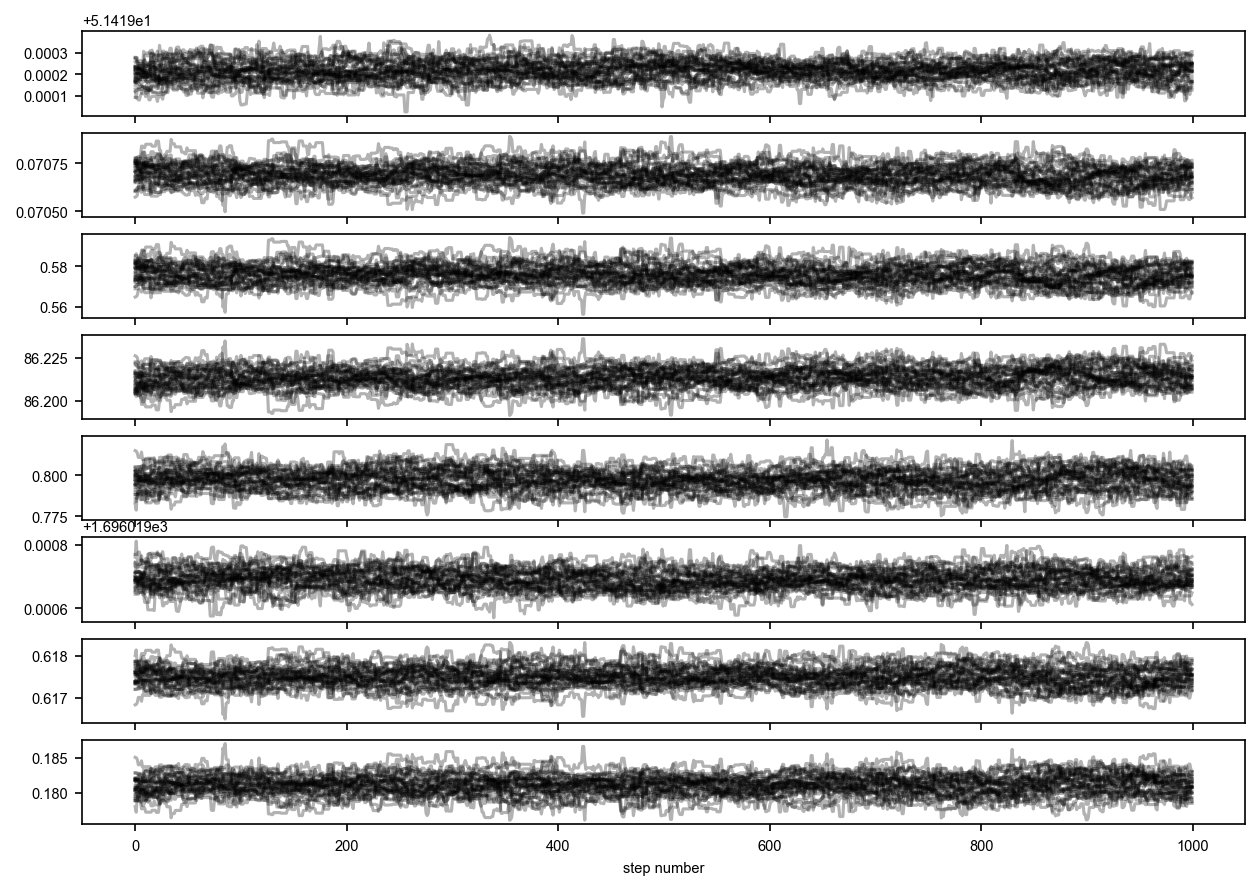

In [43]:
fig, axes = plt.subplots(len(flat_samples.T), figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [199]:
flat_samples = sampler.get_chain(discard=discard,flat=True)

# rsum, rratio, incl, sbratio, t0, f_c, f_s = params

In [200]:
eccen, omega = flat_samples[:,7]**2 + flat_samples[:,6]**2, np.arctan(flat_samples[:,7] / flat_samples[:,6])

In [201]:
full_trace = np.append(np.append(flat_samples[:,0:6],eccen[:,None], axis=1), omega[:,None], axis=1)

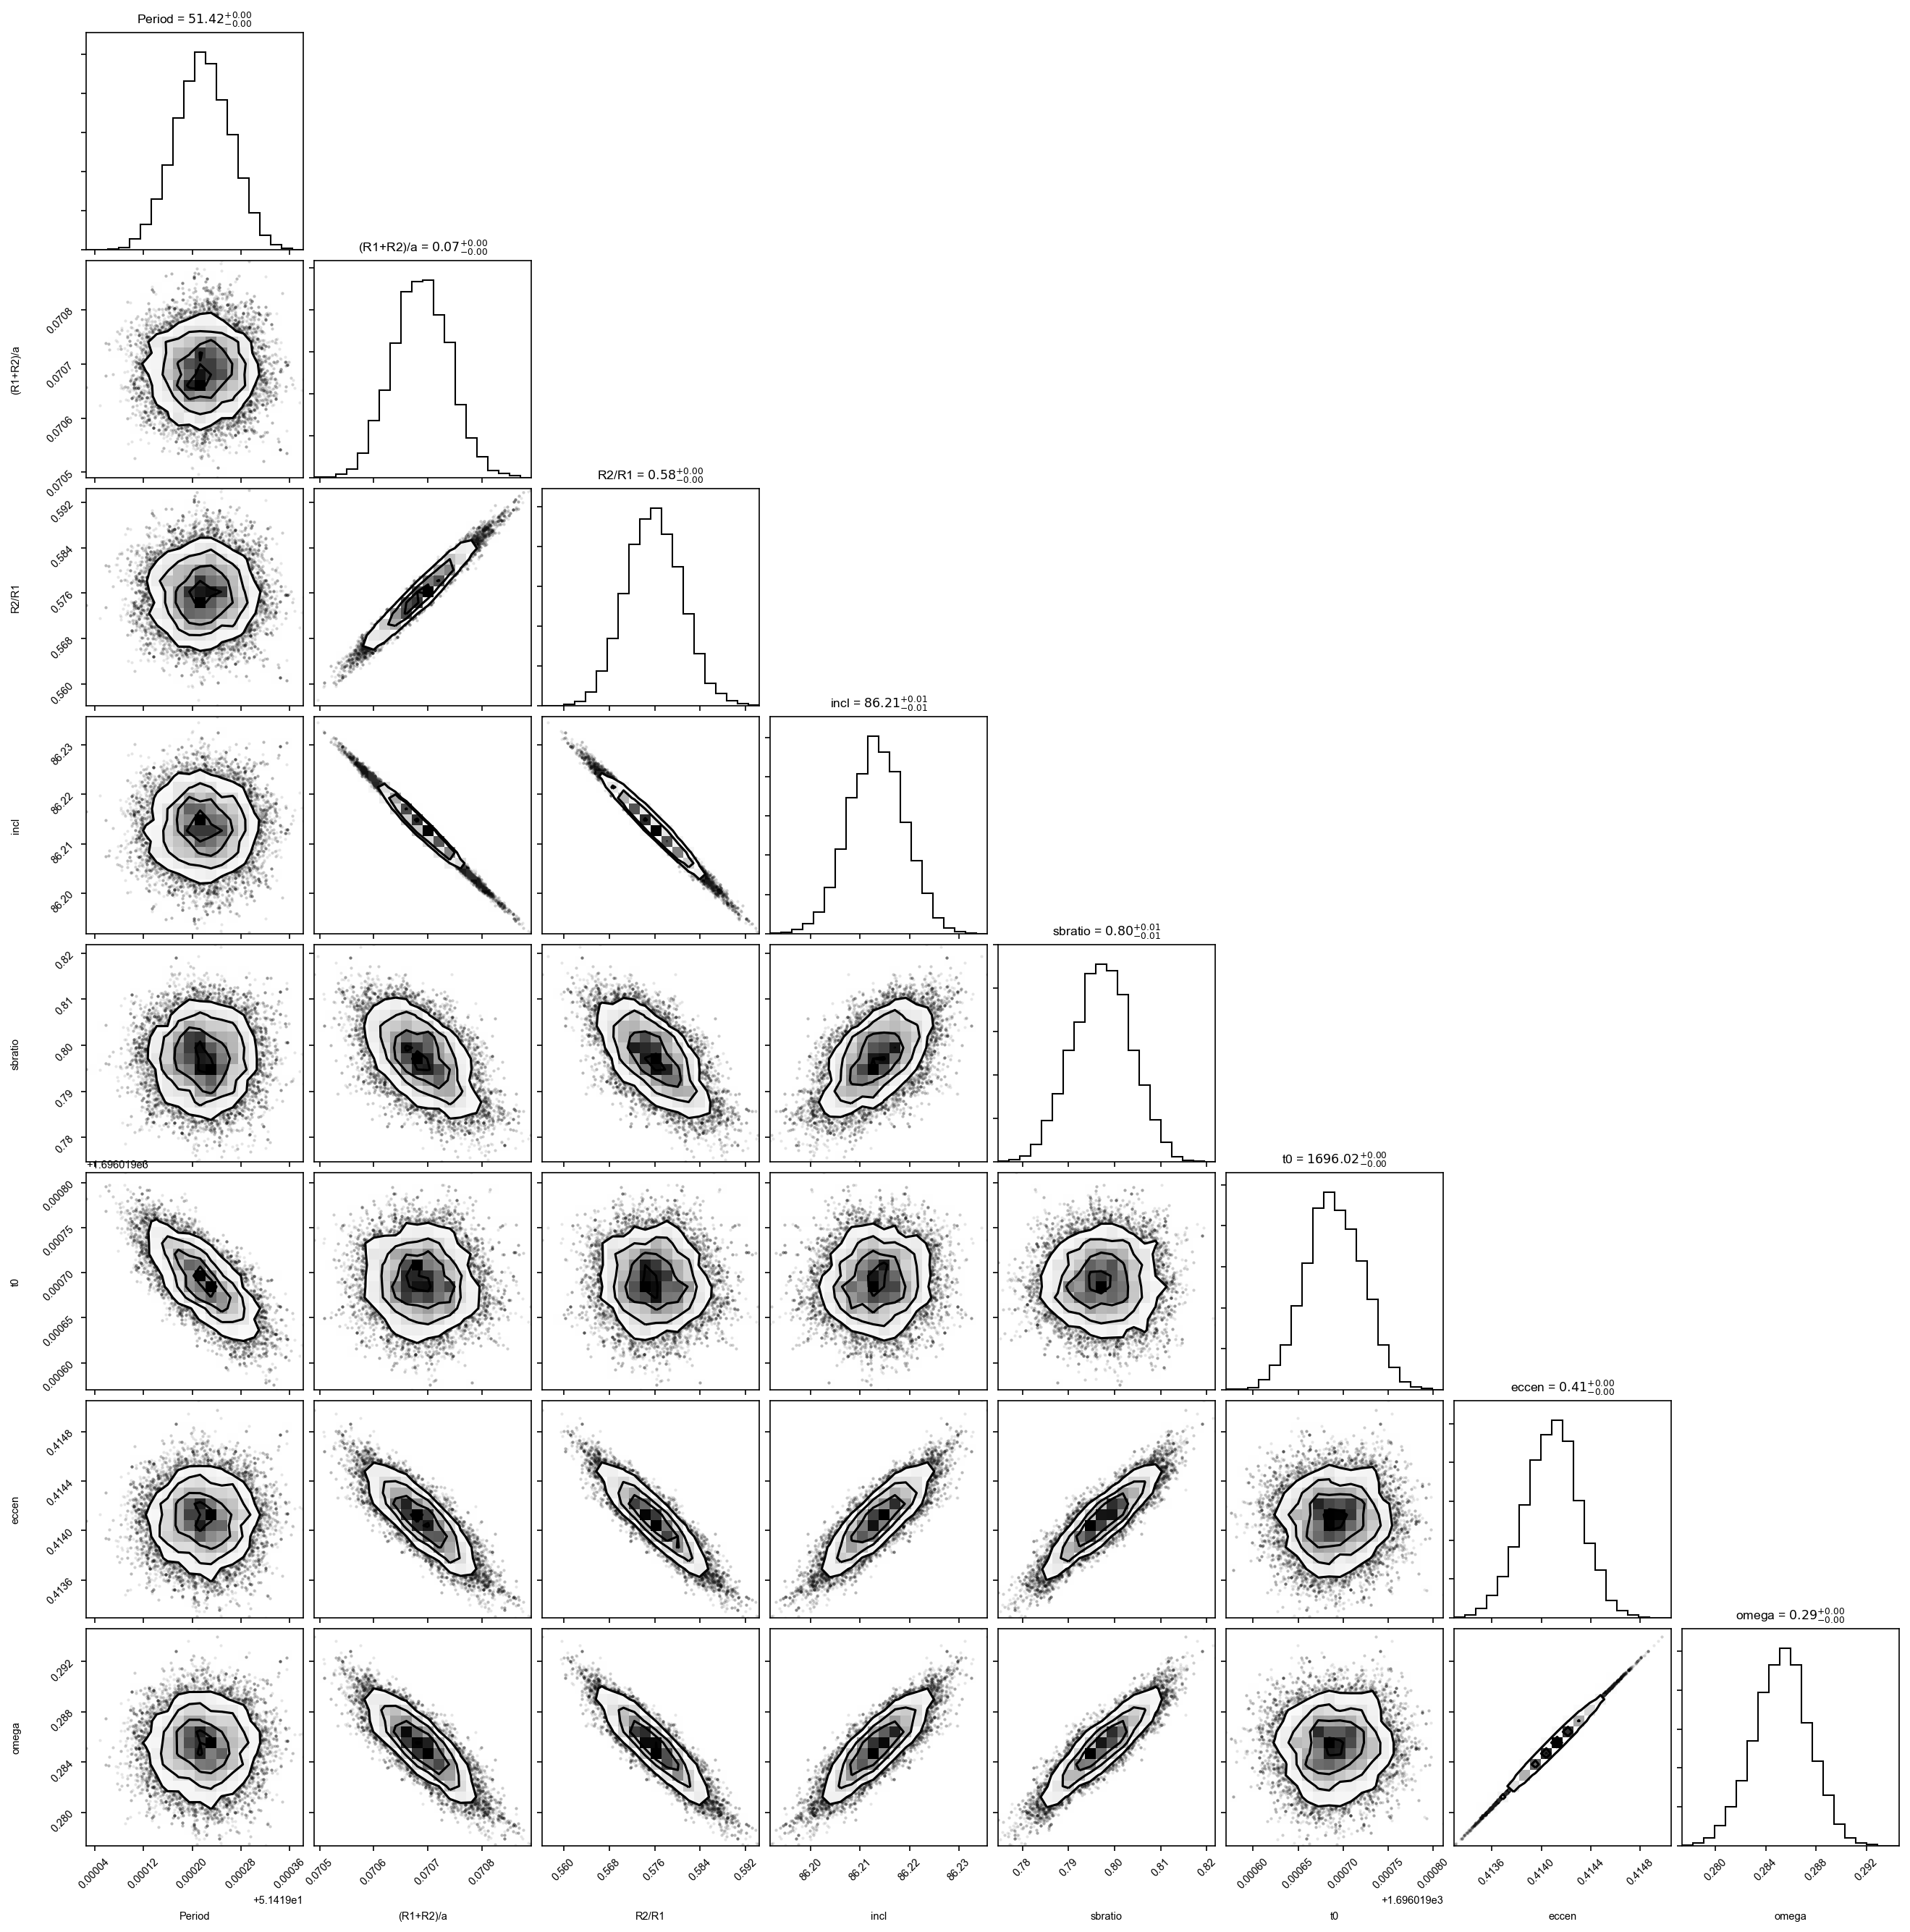

In [202]:
import corner
# flat_samples = sampler.get_chain(flat=True)
#incl, r1, r2, sbratio, q
corner.corner(full_trace, 
              labels=['Period', '(R1+R2)/a', 'R2/R1', 'incl', 'sbratio', 't0', 'eccen', 'omega'], show_titles=True, smooth=0.3
             );
# plt.savefig('ellc_fit.png', dpi=300)

In [203]:
rsum, rratio = np.median(flat_samples[:,1]), np.median(flat_samples[:,2])

rsum/(1.+rratio), rsum*rratio/(1.+rratio)

(0.04485755690426565, 0.025829728775319333)

In [30]:
0.04485755690426565 * 50 / np.sin(np.radians(86.213))

2.247785931471118

In [ ]:
49.7

In [35]:
np.sin(np.radians(180))

1.2246467991473532e-16

In [146]:
params = ['Period', '(R1+R2)/a', 'R2/R1', 'incl', 'sbratio', 't0', 'eccen', 'omega']
# fits = np.percentile(full_trace, axis=0, q=[15.83, 50, 84.16])
for param, i in zip(params, full_trace.T):
#     vals = (np.percentile(i, axis=0, q=[15.83, 50, 84.16]))
#     print('{}, {:.4f}+{:.4f}-{:.4f}'.format(param, vals[1], vals[1] - vals[0], vals[2] - vals[1]))
    mean = np.mean(i, axis=0)
    sd = np.std(i, axis=0)
    print(f'{param}, {mean:.3f}, {sd:.3f}')

Period, 51.419, 0.000
(R1+R2)/a, 0.071, 0.000
R2/R1, 0.576, 0.005
incl, 86.213, 0.006
sbratio, 0.797, 0.006
t0, 1696.020, 0.000
eccen, 0.414, 0.000
omega, 0.285, 0.002


In [204]:
np.mean(i, axis=0)

0.28525533522518426

In [121]:
full_transit_time, full_transit_flux, full_transit_err = np.hstack([t_transit, t_transit2, t_transit3]), np.hstack([y_transit, y_transit2, y_transit3]), np.hstack([yerr_transit, yerr_transit2, yerr_transit3])

# full_transit_time = full_transit_time[::20]
# full_transit_flux = full_transit_flux[::20]
# full_transit_err = full_transit_err[::20]

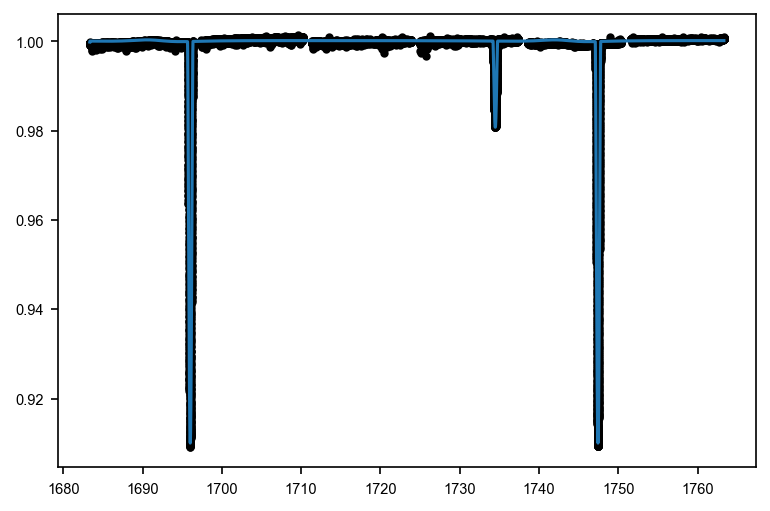

In [126]:


lc =model(np.median(flat_samples, axis=0), t)

plt.plot(t,y, '.k')
plt.plot(t, lc)

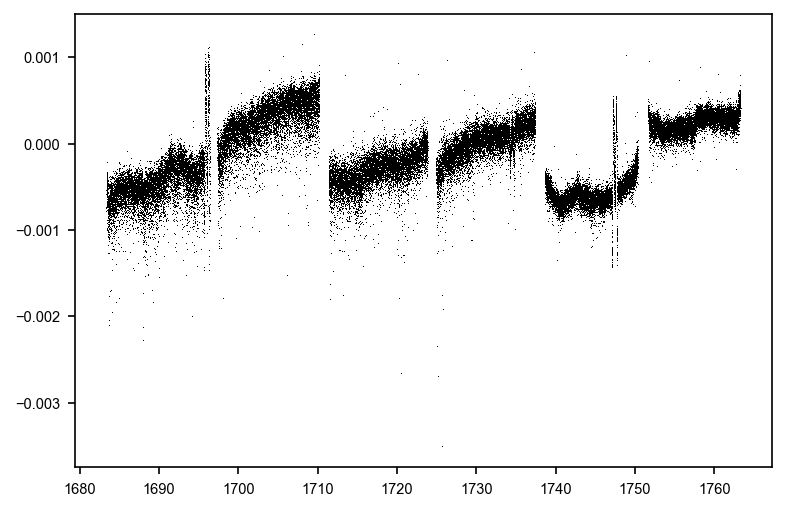

In [127]:
plt.plot(t, y - lc, ',k')

In [52]:
rsum, rratio = 6.65722266e-02, 3.23674077e-01

rsum/(1.+rratio), rsum*rratio/(1.+rratio)

(0.05029351843988708, 0.01627870816011293)

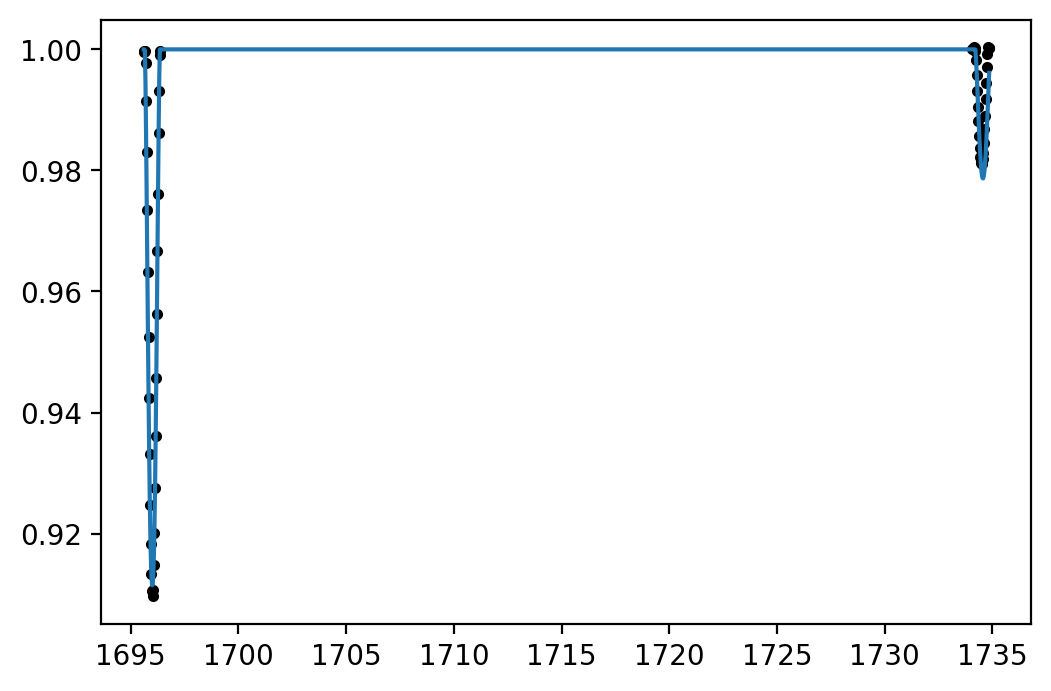

In [97]:
f_c = 0.6071025773236461
f_s = 0.24107770657401392

lc = ellc.lc(full_transit_time,t_zero=t0_guess, q=0.924,
        radius_1=0.05029351843988708, radius_2=0.01627870816011293,
         incl=86.86633416388645,
         sbratio=0.6,
         period=51.472162, f_c=f_c, f_s=f_s)

plt.plot(full_transit_time,full_transit_flux, '.k')
plt.plot(full_transit_time, lc)

In [28]:
rsum, rratio = np.median(flat_samples[:,0]), np.median(flat_samples[:,1])
r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
r1 * 43, r2 * 43

(2.09671655037225, 0.7107321813955482)